In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Oxford-IIIT Pet Dataset

- **Categories**: 37 pet breeds (dogs and cats)
- **Total Images**: 7,349
- **Image Resolution**: 224x224 pixels
- **Tasks**:
  - Classification (37 breeds)
  - Segmentation (pixel-level annotations)
- **Dataset Split**:
  - Training: 60%
  - Validation: 20%
  - Test: 20%
- **Image Format**: RGB images
- **Annotations**: Classification labels, segmentation masks


In [2]:
import tensorflow as tf
import time
import os
import numpy as np
from tensorflow.keras import layers, callbacks, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report
from datetime import datetime
import os

In [3]:
# === Settings ===
IMG_SIZE = 96
BATCH_SIZE = 8
EPOCHS = 20
USE_SUBSET = False
SUBSET_RATIO = 0.8
SAVE_DIR = "saved_models"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [4]:
import tensorflow_datasets as tfds

ds_splits, ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

train_ds, val_ds, test_ds = ds_splits

In [5]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2576
736
368


In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [7]:
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

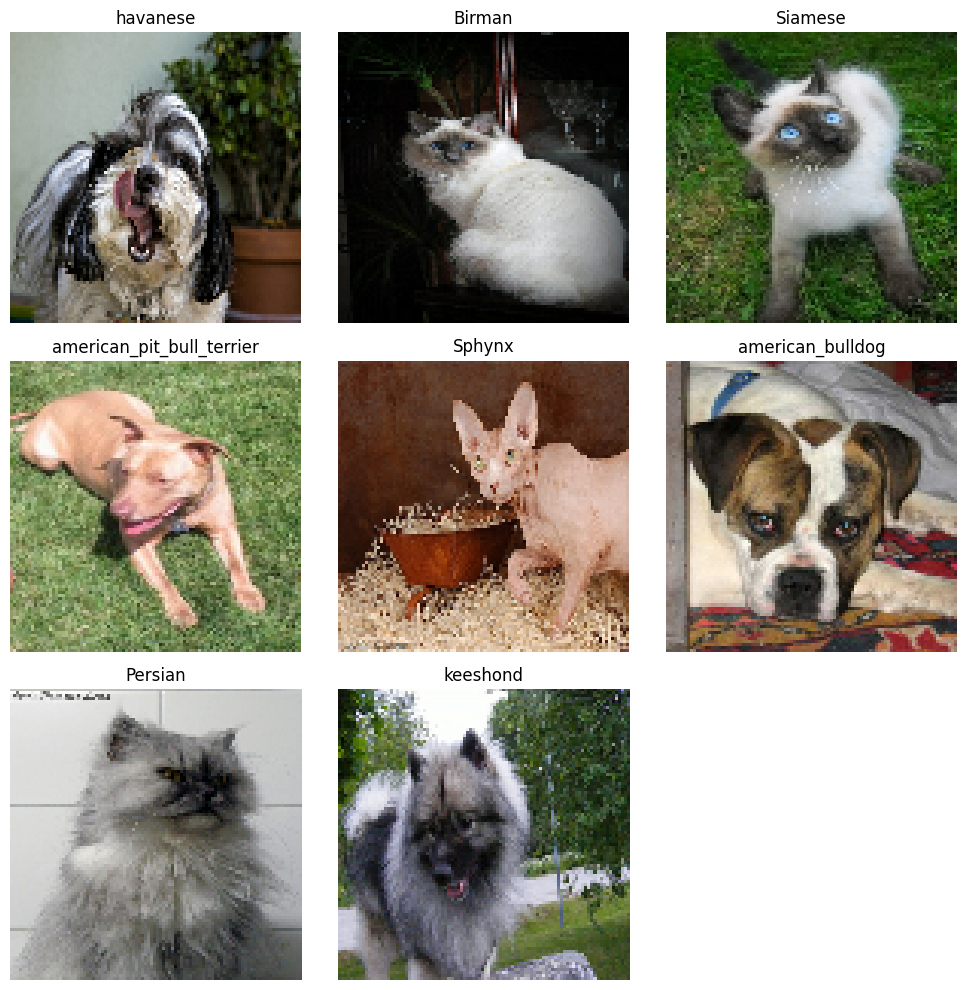

In [8]:
import matplotlib.pyplot as plt

# === 4. Show sample images from a batch safely ===
def show_batch_samples(batch_images, batch_labels, class_names):
    count = min(9, batch_images.shape[0])  # avoid index out of range
    plt.figure(figsize=(10, 10))
    for i in range(count):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch_images[i].numpy())
        plt.title(class_names[batch_labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Get label names
class_names = ds_info.features['label'].names

# Take 1 batch and display safely
for batch_images, batch_labels in train_ds.take(1):
    show_batch_samples(batch_images, batch_labels, class_names)
    plt.show()

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Load the pre-trained model
finetuned_model = load_model('/content/drive/MyDrive/Digitised work/mobilenet_model.h5')

In [10]:
# Print the model summary to examine layers
finetuned_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,244 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [11]:
# Pop the last layer
finetuned_model.pop()

<Dense name=dense_1, built=True>

In [12]:
# Print the model summary to examine layers
finetuned_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,421,954 (9.24 MB)

 Trainable params: 163,968 (640.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [13]:
# Get the output shape of the second to last layer
output_layer = finetuned_model.layers[-1].output
output_layer

<KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_325>

In [14]:
# # Add a new dense layer with 37 output units
# new_last_layer = Dense(37, activation='softmax', name='new_predictions')(output_layer)

In [15]:
# Add the new Dense layer instance
finetuned_model.add(Dense(37, activation='softmax', name='new_predictions'))

In [16]:
# Let's see the updated summary
finetuned_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_predictions (Dense)         │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,727 (9.26 MB)

 Trainable params: 168,741 (659.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [17]:
# === Freeze base for feature extraction (can unfreeze for fine-tuning later) ===
# Unfreeze all layers of the base model
finetuned_model.trainable = True

# Freeze all layers except the last 3
for layer in finetuned_model.layers[:-3]:
    layer.trainable = False

In [18]:
# Access the last layer of the base model
last_layer = finetuned_model.layers[-1]
print(f"Last layer name: {last_layer.name}")
print(f"Last layer type: {type(last_layer)}")

# Get the output shape from the layer's output tensor
print(f"Last layer output shape: {last_layer.output.shape}")

Last layer name: new_predictions
Last layer type: <class 'keras.src.layers.core.dense.Dense'>
Last layer output shape: (None, 37)


In [19]:
# for layer in base_model.layers:
#     print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

In [20]:
# # === Add classification head instead of the last fully connection layer  ===
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='leaky_relu'),
#     layers.Dropout(0.2),
#     layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
# ])

In [21]:
model = finetuned_model

In [22]:
# required callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(SAVE_DIR, 'mobilenet_model_pet_37_cls.h5'),
    monitor='val_loss',
    save_best_only=True
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [23]:
# === Compile the model ===
from tensorflow.keras.optimizers import AdamW

# Use AdamW with weight decay
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# === Summary ===
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_predictions (Dense)         │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,725 (9.26 MB)

 Trainable params: 168,741 (659.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
import time

start_time = time.time()

# === Train the model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

end_time = time.time()

Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0821 - loss: 3.7960

322/322 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.0824 - loss: 3.7943 - val_accuracy: 0.4171 - val_loss: 2.3363 - learning_rate: 1.0000e-04
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4433 - loss: 2.0969

322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.4435 - loss: 2.0963 - val_accuracy: 0.6223 - val_loss: 1.4698 - learning_rate: 1.0000e-04
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6480 - loss: 1.3509

322/322 ━━━━━━━━━━━━━━━━━━━━ 55s 149ms/step - accuracy: 0.6481 - loss: 1.3506 - val_accuracy: 0.6957 - val_loss: 1.1103 - learning_rate: 1.0000e-04
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7261 - loss: 0.9724

322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.7261 - loss: 0.9724 - val_accuracy: 0.7160 - val_loss: 0.9589 - learning_rate: 1.0000e-04
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7796 - loss: 0.7899

322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.7796 - loss: 0.7898 - val_accuracy: 0.7364 - val_loss: 0.8893 - learning_rate: 1.0000e-04
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8251 - loss: 0.6189

322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.8251 - loss: 0.6189 - val_accuracy: 0.7459 - val_loss: 0.8259 - learning_rate: 1.0000e-04
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8497 - loss: 0.5270

322/322 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8496 - loss: 0.5271 - val_accuracy: 0.7473 - val_loss: 0.7991 - learning_rate: 1.0000e-04
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8819 - loss: 0.4511

322/322 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.8819 - loss: 0.4511 - val_accuracy: 0.7391 - val_loss: 0.7844 - learning_rate: 1.0000e-04
Epoch 9/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9041 - loss: 0.3788

322/322 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9040 - loss: 0.3788 - val_accuracy: 0.7527 - val_loss: 0.7707 - learning_rate: 1.0000e-04
Epoch 10/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9157 - loss: 0.3351

322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.9157 - loss: 0.3351 - val_accuracy: 0.7527 - val_loss: 0.7483 - learning_rate: 1.0000e-04
Epoch 11/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9146 - loss: 0.3237

322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.9146 - loss: 0.3236 - val_accuracy: 0.7595 - val_loss: 0.7406 - learning_rate: 1.0000e-04
Epoch 12/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9244 - loss: 0.2714

322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9244 - loss: 0.2714 - val_accuracy: 0.7582 - val_loss: 0.7346 - learning_rate: 1.0000e-04
Epoch 13/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.9574 - loss: 0.2097 - val_accuracy: 0.7582 - val_loss: 0.7417 - learning_rate: 1.0000e-04
Epoch 14/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9578 - loss: 0.1842

322/322 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.9578 - loss: 0.1843 - val_accuracy: 0.7649 - val_loss: 0.7346 - learning_rate: 1.0000e-04
Epoch 15/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9683 - loss: 0.1702

322/322 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9683 - loss: 0.1702 - val_accuracy: 0.7568 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 16/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9695 - loss: 0.1512

322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.9695 - loss: 0.1512 - val_accuracy: 0.7636 - val_loss: 0.7268 - learning_rate: 1.0000e-04
Epoch 17/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9757 - loss: 0.1335

322/322 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9757 - loss: 0.1335 - val_accuracy: 0.7622 - val_loss: 0.7246 - learning_rate: 1.0000e-04
Epoch 18/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.9786 - loss: 0.1231 - val_accuracy: 0.7554 - val_loss: 0.7379 - learning_rate: 1.0000e-04
Epoch 19/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.9810 - loss: 0.1147 - val_accuracy: 0.7690 - val_loss: 0.7334 - learning_rate: 1.0000e-04
Epoch 20/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.9919 - loss: 0.0808 - val_accuracy: 0.7636 - val_loss: 0.7293 - learning_rate: 1.0000e-04


In [25]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
import tensorflow as tf
import numpy as np

def extract_images_and_labels(dataset):
  """
  Extracts all images and labels from a TensorFlow Dataset.

  Args:
    dataset: A tf.data.Dataset object that yields tuples of (images, labels).
             It is assumed that the images tensor has a shape where the
             first dimension is the batch size. The labels tensor also has
             a first dimension corresponding to the batch size.

  Returns:
    A tuple containing:
      - images_list: A NumPy array containing all the images from the dataset.
                     Shape will be (num_samples, height, width, channels).
      - labels_list: A NumPy array containing all the corresponding labels.
                     Shape will be (num_samples,).
  """
  all_images = []
  all_labels = []
  for images, labels in dataset:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())
  return np.array(all_images), np.array(all_labels)

# Example usage with your test_ds:
x_test, y_test = extract_images_and_labels(test_ds)

# Now test_images is a NumPy array of your test images
# and test_labels is a NumPy array of your test labels

print(f"Shape of test images: {x_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

# You can now use test_images to test your model, for example:
# predictions = new_model.predict(test_images)

Shape of test images: (368, 96, 96, 3)
Shape of test labels: (368,)


In [27]:
# Resize and normalize x_test before evaluation
x_test_resized = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))  # IMG_SIZE should be 96 for MobileNetV2
x_test_resized = x_test_resized

# Evaluate model
eval_loss, eval_acc = model.evaluate(x_test_resized, y_test, verbose=0)

# Predict
y_pred = np.argmax(model.predict(x_test_resized), axis=1)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

result = {
    "model": 'mobilenetV2',
    "accuracy": eval_acc,
    "loss": eval_loss,
    "training_time_sec": round(end_time - start_time, 2),
    "precision": report['weighted avg']['precision'],
    "recall": report['weighted avg']['recall'],
    "f1_score": report['weighted avg']['f1-score'],
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step


In [28]:
result

{'model': 'mobilenetV2',
 'accuracy': 0.77173912525177,
 'loss': 0.7732906341552734,
 'training_time_sec': 761.6,
 'precision': 0.7795179482619541,
 'recall': 0.7717391304347826,
 'f1_score': 0.767830046086017}

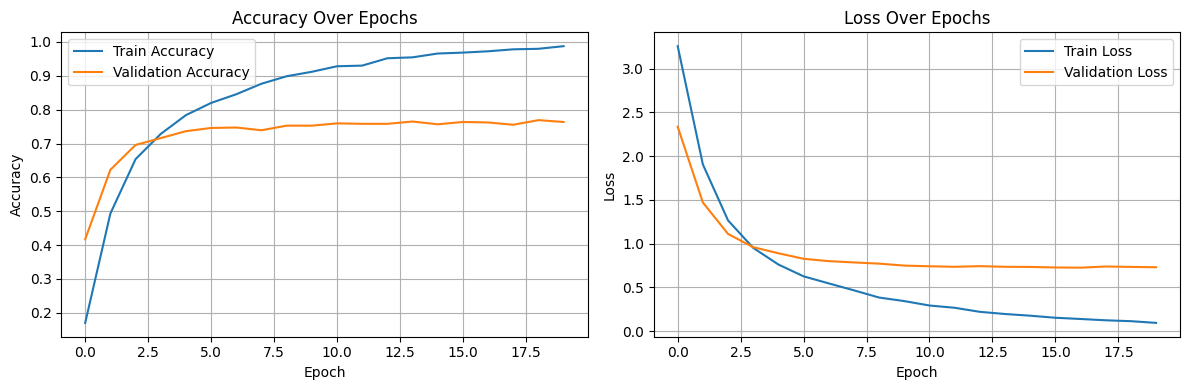

<ipython-input-29-e744b19c152f>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


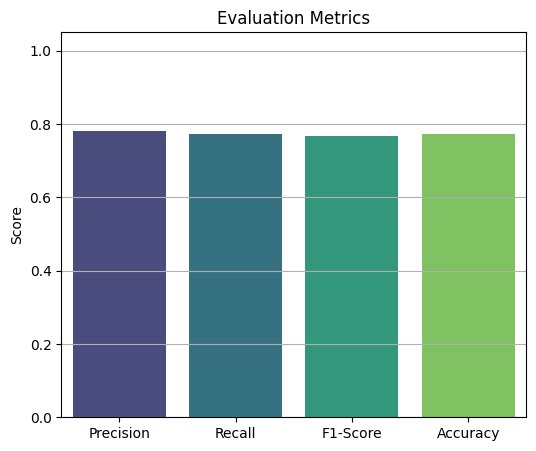

In [29]:
import matplotlib.pyplot as plt

# === 1. Accuracy Plot ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === 2. Loss Plot ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === 3. Evaluation Metrics Bar Chart ===
import seaborn as sns

metrics = {
    'Precision': result['precision'],
    'Recall': result['recall'],
    'F1-Score': result['f1_score'],
    'Accuracy': result['accuracy']
}

plt.figure(figsize=(6, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.ylim(0, 1.05)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

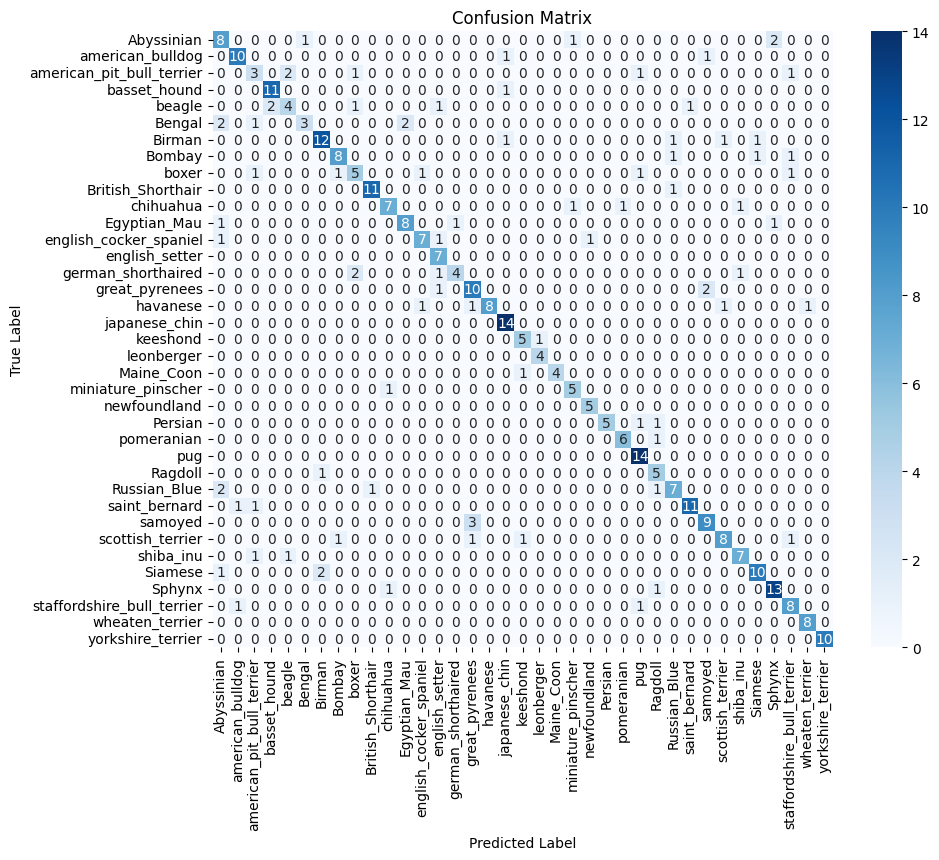

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# # Predict
# y_pred = np.argmax(model.predict(x_test_resized), axis=1)

# # Predict classes
# y_pred = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# CIFAR-10 class names
# Get label names
class_names = ds_info.features['label'].names

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### save model as .h5 and .tflite versions

In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# === Load the Saved Model ===
model = load_model(os.path.join(SAVE_DIR, 'mobilenet_model_pet_37_cls.h5'))

# === Convert to TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: optimize for size/speed (e.g., post-training quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# === Convert the model ===
tflite_model = converter.convert()

# === Save the TFLite model to file ===
tflite_model_path = os.path.join(SAVE_DIR, 'mobilenet_model_pet_37_cls.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Saved artifact at '/tmp/tmptgvnaxu4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  135923892368016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131985360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131983440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921222228624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131985552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131986512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131986896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131987280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131987088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135921131985168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13592113198843

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!ls "/content/drive/MyDrive/Digitised work"

mobilenet_model_finetuned.h5	  mobilenet_model.h5
mobilenet_model_finetuned.tflite  mobilenet_model.tflite


In [34]:
!cp "/content/saved_models/mobilenet_model_pet_37_cls.h5" "/content/drive/MyDrive/Digitised work"
!cp "/content/saved_models/mobilenet_model_pet_37_cls.tflite" "/content/drive/MyDrive/Digitised work"